# Лабораторная работа 1

Задача - реализовать и обучить классификаторы (кнн, логистическая регрессия, свм, наивный байес)

### Обработка данных

In [1]:
import pandas as pd

df = pd.read_csv('data.csv')

In [2]:
df.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


In [3]:
numerical = ['parent_age', 'parent_salary', 'house_area', 'average_grades']
categorical = ['type_school', 'school_accreditation', 'gender', 'interest', 'residence', 'parent_was_in_college']
target = 'in_college'

В прошлой лабе выяснили, что количественные фичи распределены нормально. Стоит свести их распределения к стандартным нормальным с помощью стандарт скейлера.

Категориальные фичи закодируем через one hot encoding.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [6]:
preprocessing = ColumnTransformer([
    ('one_hot', OneHotEncoder(drop='if_binary'), categorical),
    ('scaler', StandardScaler(), numerical),
])

Разделим данные на две выборки - обучающую и тестовую.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.drop(target, axis=1)
y = df[target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [11]:
X_train.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college
91,Vocational,B,Male,Quiet Interested,Urban,54,3240000,54.5,81.70,False
153,Academic,B,Female,Uncertain,Rural,52,4890000,109.1,80.65,True
855,Academic,A,Male,Quiet Interested,Urban,54,6500000,57.0,82.37,False
878,Vocational,B,Male,Very Interested,Rural,51,4870000,92.1,81.69,True
75,Vocational,B,Female,Quiet Interested,Urban,55,4200000,51.2,84.02,False


In [12]:
y_train.head()

91     False
153     True
855    False
878    False
75     False
Name: in_college, dtype: bool

Функция для оценивания модели:

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [14]:
import matplotlib.pyplot as plt

In [15]:
def validate_model(model, X, y_real):
    y_pred = model.predict(X)
    print('Accuracy: ', accuracy_score(y_real, y_pred))
    print('Precision: ', precision_score(y_real, y_pred))
    print('Recall: ', recall_score(y_real, y_pred))
    cm = confusion_matrix(y_real, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.show()

## Обучение моделей

In [30]:
import numpy as np
import pickle
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.model_selection import GridSearchCV

### KNN

Обучение: запоминаем всю выборку  
Предсказание: ищем k ближайших соседей для каждого объекта, выдаем тот класс, соседей которого больше.

In [20]:
from sklearn.metrics import euclidean_distances

class MyKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X = X
        self.y = y
        return self
    
    def predict(self, X):
        X = check_array(X)    
        y = np.ndarray((X.shape[0],))
        for (i, elem) in enumerate(X):
            distances = euclidean_distances([elem], self.X)[0]
            neighbors = np.argpartition(distances, kth = self.n_neighbors-1)
            nearest_neighbors = neighbors[:self.n_neighbors]
            labels, cnts = np.unique(self.y[nearest_neighbors], return_counts=True)
            y[i] = labels[cnts.argmax()]
        return y

In [27]:
knn_pipe = Pipeline(steps=[('preprocessing', preprocessing), ('knn', MyKNN())])

knn_grid = GridSearchCV(knn_pipe, {'knn__n_neighbors': [2, 3, 4, 5]})
knn_grid.fit(X_train, y_train);

In [28]:
knn_grid.best_params_

{'knn__n_neighbors': 3}

Accuracy:  0.88
Precision:  0.9175257731958762
Recall:  0.8476190476190476


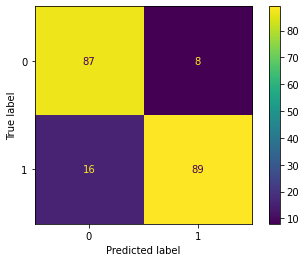

In [29]:
validate_model(knn_grid, X_test, y_test)

In [32]:
f = open("knn.pkl", "wb")
pickle.dump(knn_grid, f, pickle.HIGHEST_PROTOCOL)
f.close()

### KNN from Sklearn

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
knn_pipe_sklearn = Pipeline(steps=[('preprocessing', preprocessing), ('knn', KNeighborsClassifier())])

knn_grid_sklearn = GridSearchCV(knn_pipe_sklearn, {'knn__n_neighbors': [2, 3, 4, 5]})
knn_grid_sklearn.fit(X_train, y_train);

In [56]:
knn_grid_sklearn.best_params_

{'knn__n_neighbors': 3}

Accuracy:  0.88
Precision:  0.9175257731958762
Recall:  0.8476190476190476


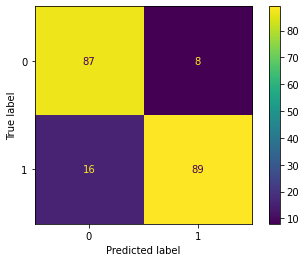

In [57]:
validate_model(knn_grid_sklearn, X_test, y_test)

In [58]:
f = open("knn_sklearn.pkl", "wb")
pickle.dump(knn_grid_sklearn, f, pickle.HIGHEST_PROTOCOL)
f.close()

Результат работы моей реализации полностью совпал с результатом реализации склерна.

### Логистическая регрессия

Обучение: подбираем коэффициенты линейной комбинации так, чтобы MSE была минимальной (с помощью градиентного спуска)  
Предсказание: применяем полученную формулу ко всем объектам, затем навешиваем сигмоиду, чтобы перейти к вероятностям

In [38]:
def sigmoid(a):
    return 1. / (1 + np.exp(-a))

In [39]:
class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=10, lr=0.1, batch_size=64):
        self.w = None
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n, k = X.shape
        self.w = np.random.randn(k + 1)

        # добавим смещение
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        for i in range(self.epochs):
            for j in range(0, len(X), self.batch_size):
                X_batch = X[j:j+self.batch_size]
                y_batch = y[j:j+self.batch_size]
                
                # градиентный спуск
                y_pred = sigmoid(np.dot(X_batch, self.w))
                self.w -= self.lr * (X_batch.T @ (y_pred - y_batch))
        return self
        
    def predict(self, X, threshold=0.5):
        X = check_array(X)
        n = X.shape[0]
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(np.dot(X, self.w)) > threshold

In [50]:
log_reg_pipe = Pipeline(steps=[('preprocessing', preprocessing), ('logreg', MyLogisticRegression())])

log_reg_grid = GridSearchCV(log_reg_pipe, {'logreg__lr': [0.001, 0.01, 0.1], 'logreg__epochs': [3, 5, 7, 10]})
log_reg_grid.fit(X_train, y_train);

In [51]:
log_reg_grid.best_params_

{'logreg__epochs': 10, 'logreg__lr': 0.01}

Accuracy:  0.84
Precision:  0.8543689320388349
Recall:  0.8380952380952381


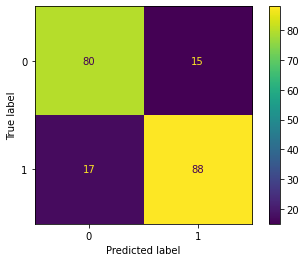

In [52]:
validate_model(log_reg_grid, X_test, y_test)

In [53]:
f = open("log_reg.pkl", "wb")
pickle.dump(log_reg_grid, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Логистическая регрессия из Sklearn

In [54]:
from sklearn.linear_model import LogisticRegression

Будем подбирать наилучший коэффициент С (отвечает за регуляризацию)

In [59]:
log_reg_pipe_sklearn = Pipeline(steps=[('preprocessing', preprocessing), ('logreg', LogisticRegression())])

log_reg_grid_sklearn = GridSearchCV(log_reg_pipe_sklearn, {'logreg__C': [0.01, 0.1, 1, 10]})
log_reg_grid_sklearn.fit(X_train, y_train);

In [60]:
log_reg_grid_sklearn.best_params_

{'logreg__C': 10}

Accuracy:  0.835
Precision:  0.8529411764705882
Recall:  0.8285714285714286


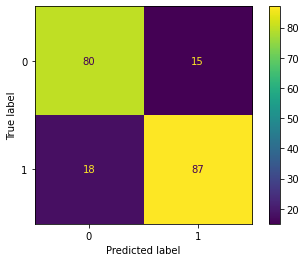

In [61]:
validate_model(log_reg_grid_sklearn, X_test, y_test)

In [62]:
f = open("log_reg_sklearn.pkl", "wb")
pickle.dump(log_reg_grid_sklearn, f, pickle.HIGHEST_PROTOCOL)
f.close()

Результаты работы двух реализаций алгоритма почти одинаковые

### SVM

Обучение: строим разделяющую гиперплоскость  
Предсказание: смотрим, с какой стороны от гиперплоскости находятся объекты

In [63]:
class MySVM(ClassifierMixin, BaseEstimator):
    def __init__(self, epochs=10, lr=0.1, alpha=0.1):
        self.w = None
        self.epochs = epochs
        self.lr = lr
        self.alpha = alpha
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        y = np.where(y == 1, 1, -1) # переводим таргеты из 0/1 в -1/1
        n, k = X.shape
        self.w = np.random.randn(k + 1)
        
        # добавим смещение
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        for i in range(self.epochs):
            for j, x in enumerate(X):
                margin = y[j] * np.dot(self.w, x)
                if margin >= 1:
                    self.w -= self.lr * self.alpha * self.w / self.epochs
                else:
                    self.w += self.lr * (y[j] * x - self.alpha * self.w / self.epochs)
        return self
    
    def predict(self, X):
        X = check_array(X)
        n, k = X.shape
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        y = np.ndarray((n))
        
        for i, elem in enumerate(X):
            prediction = np.dot(self.w, elem)
            y[i] = (prediction > 0)
        return y

In [67]:
svm_pipe = Pipeline(steps=[('preprocessing', preprocessing), ('svm', MySVM())])

svm_grid = GridSearchCV(svm_pipe, {'svm__lr': [0.001, 0.01, 0.1], 
                                   'svm__epochs': [3, 5, 7, 10], 
                                   'svm__alpha': [0.01, 0.1, 1, 10]})
svm_grid.fit(X_train, y_train);

In [68]:
svm_grid.best_params_

{'svm__alpha': 0.01, 'svm__epochs': 10, 'svm__lr': 0.01}

Accuracy:  0.85
Precision:  0.8787878787878788
Recall:  0.8285714285714286


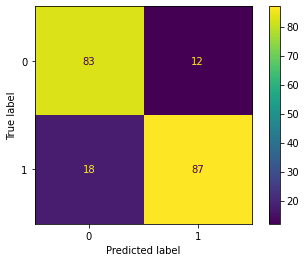

In [69]:
validate_model(svm_grid, X_test, y_test)

In [71]:
f = open("svm.pkl", "wb")
pickle.dump(svm_grid, f, pickle.HIGHEST_PROTOCOL)
f.close()

### SVM from Sklearn

In [70]:
from sklearn.svm import LinearSVC

In [72]:
svm_pipe_sklearn = Pipeline(steps=[('preprocessing', preprocessing), ('svm', LinearSVC())])

svm_grid_sklearn = GridSearchCV(svm_pipe_sklearn, {'svm__C': [0.01, 0.1, 1, 10]})
svm_grid_sklearn.fit(X_train, y_train);

C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

In [73]:
svm_grid_sklearn.best_params_

{'svm__C': 10}

Accuracy:  0.835
Precision:  0.8529411764705882
Recall:  0.8285714285714286


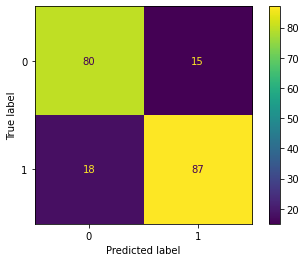

In [74]:
validate_model(svm_grid_sklearn, X_test, y_test)

In [75]:
f = open("svm_sklearn.pkl", "wb")
pickle.dump(svm_grid_sklearn, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Naive Bayes

Обучение: запоминаем параметры распределений фичей  
Предсказание: считаем условные вероятности принадлежности ко всем классам и берем класс с наибольшей вероятностью

In [86]:
class MyNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        labels, counts = np.unique(y, return_counts=True)
        self.labels = labels
        
        # запоминаем параметры распределения
        self.freq = np.array([cnt / y.shape[0] for cnt in counts])
        self.means = np.array([X[y == label].mean(axis = 0) for label in labels])
        self.stds = np.array([X[y == label].std(axis = 0) for label in labels])
        return self
    
    def predict(self, X):
        X = check_array(X)
        y = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            cur_freq = np.array(self.freq)
            for j in range(len(self.labels)):
                # P(класс = j | X)
                p = np.array([self.gaussian(self.means[j][k], self.stds[j][k], x[k]) for k in range(X.shape[1])])
                cur_freq[j] *= np.prod(p)
            y[i] = np.argmax(cur_freq)
        return y
    
    def gaussian(self, mu, sigma, x0):
        # X ~ N(mu, sigma)
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * np.pi * sigma) # функция распределения

In [87]:
bayes_pipe = Pipeline(steps=[('preprocessing', preprocessing), ('bayes', MyNaiveBayes())])
bayes_pipe.fit(X_train, y_train);

Accuracy:  0.785
Precision:  0.803921568627451
Recall:  0.780952380952381


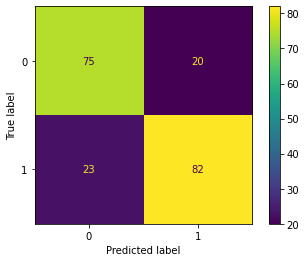

In [88]:
validate_model(bayes_pipe, X_test, y_test)

In [89]:
f = open("bayes.pkl", "wb")
pickle.dump(bayes_pipe, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Naive Bayes from Sklearn

In [90]:
from sklearn.naive_bayes import GaussianNB

In [91]:
bayes_pipe_sklearn = Pipeline(steps=[('preprocessing', preprocessing), ('bayes', GaussianNB())])
bayes_pipe_sklearn.fit(X_train, y_train);

Accuracy:  0.765
Precision:  0.7543859649122807
Recall:  0.819047619047619


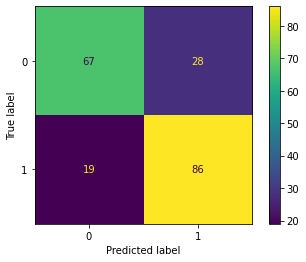

In [92]:
validate_model(bayes_pipe_sklearn, X_test, y_test)

In [93]:
f = open("bayes_sklearn.pkl", "wb")
pickle.dump(bayes_pipe_sklearn, f, pickle.HIGHEST_PROTOCOL)
f.close()

# Вывод

В этой работе я релизовал 4 алгоритма машинного обучения: КНН, логистическую регрессию, СВМ и наивного Байеса. Каждую из этих моделей я обучил, провалидировал и сравнил с реализацией из Sklearn.

Результаты всех моих моделей совпали с результатами моделей из Sklearn (ну или незначительно отличаются из-за разных алгоритмов, рандом сидов итд).

Все модели показали примерно одинаковый результат. Лучше всего отработал KNN:  
Accuracy:  0.88  
Precision:  0.9175257731958762  
Recall:  0.8476190476190476  

Но остальные алгоритмы ненамного хуже.